# Introduction

**This Notebook demonstrates how to predict churn using Big Data processing framework - Spark.** The data comes from fictive music streaming company named *Sparkify*. All the calculations in this notebook have been performed on sample data.

# Problem definition
The project aims to predict whether the user is likely to cancel the service based on the past behaviour data.
The churn event have been extracted from the Sparkify dataset using the service **cancellation confirmation** done by an user. 
The main challenge related to churn is its **frequency**. Unfortunately, machine learning algorithms do not like unbalanced datasets, which makes it even more difficult to train an effective model. There are many more challenges related to churn prediction. What time range of user activity should be taken into account? Which features are crucial ones?


## Hypotheses
There are multiple traces of what could impact churn. It's worth starting from simple questions. Why do users leave the service? Why may disturb them or discourage to the platform? Well, it's actually quite simple. I would stop using the service if the content dont match me or there are tons of bugs. I would use the less and less and one day leave it at all. When there weren't any of my friends who used the service, I would take decision to left even sooner because there wouldn't be anything what kept me there. Also, annoying ads could effectively discourage me away.

Let's break those factors impacting churn into details:
1. Decrease in number of played songs during last period vs a period before or overall smaller number of played songs than average.
1. How much time does user spend on a platform? The less time, the more possible to churn.
1. Increased number of thumbs down.
1. A little number of added contacts.
1. Unusual number of looking for settings/help page.
1. Occurence of errors
1. From how long a user use a service? New users probably are more likely to cancel the service.

In [176]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.1)


In [336]:
from pyspark.sql import session
import pyspark.sql.functions as F
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DecimalType, FloatType, ByteType, ShortType, BinaryType, BooleanType, DoubleType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, OneHotEncoderEstimator, StandardScaler, Normalizer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, BinaryLogisticRegressionSummary, GBTClassifier
# from pyspark.ml.evaluation import BinaryLogisticRegressionSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import MultilayerPerceptronClassifier
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 
import seaborn as sns
import pandas as pd
import numpy as np
from time import time

In [178]:
# create a Spark session
spark = session.SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()
DATASET_MINI_PATH = 'mini_sparkify_event_data.json'
# DATASET_MINI_PATH = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'
df = spark.read.json(DATASET_MINI_PATH)

# Data understanding

The provided dataset is a subset of larger one, containing users activity logs of *Sparkify* music service.
Dataset consits of following fields:

```root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)```

Each row stands for a log of user's action. **In order to detect churn, the `page` field is a key as it contains `Cancellation Confirmation` option.** Basically, a user that have entered `Cancellation Confirmation`, have canceled the service at all.

### Glimpse of relevant categorical columns

In [4]:
for colname in ['auth', 'gender', 'level', 'method', 'page', 'status', 'userAgent']:
    df.groupby(colname).count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526

As we can see there are over 8k of null userAgent as well as gender.

In [5]:
df.where(col("gender").isNull()).select('userId').dropDuplicates().show()

+------+
|userId|
+------+
|      |
+------+



And all of them have no `userId` assigned - probably they come from not logged users. Our area of interest is limited to activity of logged users so let's remove this activity.

In [6]:
df.where(col("gender").isNull()).select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [7]:
df = df.filter(df["userId"] != "")

In [8]:
df.where(col("gender").isNull()).select('userId').dropDuplicates().collect() # No records returned as expected

[]

As we can see most of the actions are related to logged users. Let's look at this again.

In [9]:
df.groupby(['auth', 'page']).count().show()

+---------+--------------------+------+
|     auth|                page| count|
+---------+--------------------+------+
|Logged In|              Logout|  3226|
|Logged In|           Thumbs Up| 12551|
|Logged In|         Roll Advert|  3933|
|Logged In|      Submit Upgrade|   159|
|Logged In|            Settings|  1514|
|Logged In|         Thumbs Down|  2546|
|Logged In|       Save Settings|   310|
|Logged In|                Help|  1454|
|Logged In|            NextSong|228108|
|Logged In|               About|   495|
|Logged In|     Add to Playlist|  6526|
|Logged In|               Error|   252|
|Logged In|                Home| 10082|
|Cancelled|Cancellation Conf...|    52|
|Logged In|          Add Friend|  4277|
|Logged In|           Downgrade|  2055|
|Logged In|             Upgrade|   499|
|Logged In|              Cancel|    52|
|Logged In|    Submit Downgrade|    63|
+---------+--------------------+------+



**Only 52 rows from our mini dataset are related to churn.** I will mark activity of users that picked `Cancellation Confirmation`. It's neccesarry in order to further data exploration.

In [10]:
flag_cancelled_auth_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# We know that `Cancellation Confirmation` is always the last users event.
windowval = Window.partitionBy("userId")
df = df.withColumn("cancelled", flag_cancelled_auth_event("page"))
df = df.withColumn("phase_cancelled", F.max("cancelled").over(windowval))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancelled=0, phase_cancelled=0)

Since we have marked each user that confirmed the service cancellation, we can mark each activity of such users. Before we do this, let's check if there exist any user activity after the `Cancellation Confirmation`. Theoretically, there shouldn't, however data sometimes like to surprise.

In [11]:
df.createOrReplaceTempView('traffic')
spark.sql('''
WITH thresholds AS (
    SELECT userId, ts
    FROM traffic
    WHERE cancelled = 1
)

SELECT COUNT(*)
FROM traffic 
JOIN thresholds
    ON traffic.userId = thresholds.userId AND traffic.ts > thresholds.ts
''').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



Data is consistent - there is no activity after `Cancellation Confirmation` event.

# Exploratory Data Analysis

Let's prepare some useful features for EDA:
* get date of last activity
* calculate time difference between registration date and the last activity date
* explore daily active users, daily sessions, page views, page views per user/session

In [12]:
# Convert timestamp to date and make date calculations
df = df.withColumn('datetime', F.from_unixtime(col("ts") / 1000))
df = df.withColumn('date', F.to_date("datetime"))
df = df.withColumn('month', F.month("datetime"))

# Process registration date
df = df.withColumn('datetime_registered', F.from_unixtime(col("registration") / 1000))
df = df.withColumn('date_registered', F.to_date("datetime_registered"))
df = df.withColumn('month_registered', F.month("datetime_registered"))
df = df.withColumn('days_from_registration', F.datediff(col('datetime'), col('datetime_registered')))

# Calculate:
# - DAU - daily active users
# - DS - daily sessions 
# - PV / DAU - page views per user
# - PV / DS - page views per session (later it turned out that it's close to be the same to 'per user' calculations)
# Above metrics are broken down by churned/active users.
dates = df.select('date').distinct()
pages = df.select('page').distinct()
phase_cancelled = df.select('phase_cancelled').distinct()
daily = dates.crossJoin(pages).crossJoin(phase_cancelled)


daily_users_sessions = df.groupby('date', 'phase_cancelled')\
    .agg(F.countDistinct('userId').alias('DAU'), 
         F.countDistinct('sessionId').alias('DS')
        )  # daily active users and daily sessions

daily_events = df\
    .groupby('date', 'phase_cancelled', 'page')\
    .agg(F.count('userId').alias('pageCount'))

daily = daily.join(daily_events, on=['date', 'phase_cancelled', 'page'], how='left')
daily = daily.join(daily_users_sessions, on=['date', 'phase_cancelled'], how='left')
daily = daily.withColumn('pageCountPerUser', col('pageCount') / col('DAU'))
daily = daily.withColumn('pageCountPerSession', col('pageCount') / col('DS'))
daily = daily.fillna(0)

def days(i):
    return i*86400

# Calculate moving average of page views per user (and per session) - it's easier to observe trends.
ma7_window = Window.partitionBy('phase_cancelled', 'page').orderBy(col("date").cast('timestamp').cast('long')).rangeBetween(-days(7), 0)
daily = daily.withColumn('MA7pageCountPerUser', F.mean('pageCountPerUser').over(ma7_window))
daily = daily.withColumn('MA7pageCountPerSession', F.mean('pageCountPerSession').over(ma7_window))
pd_df = daily.toPandas()

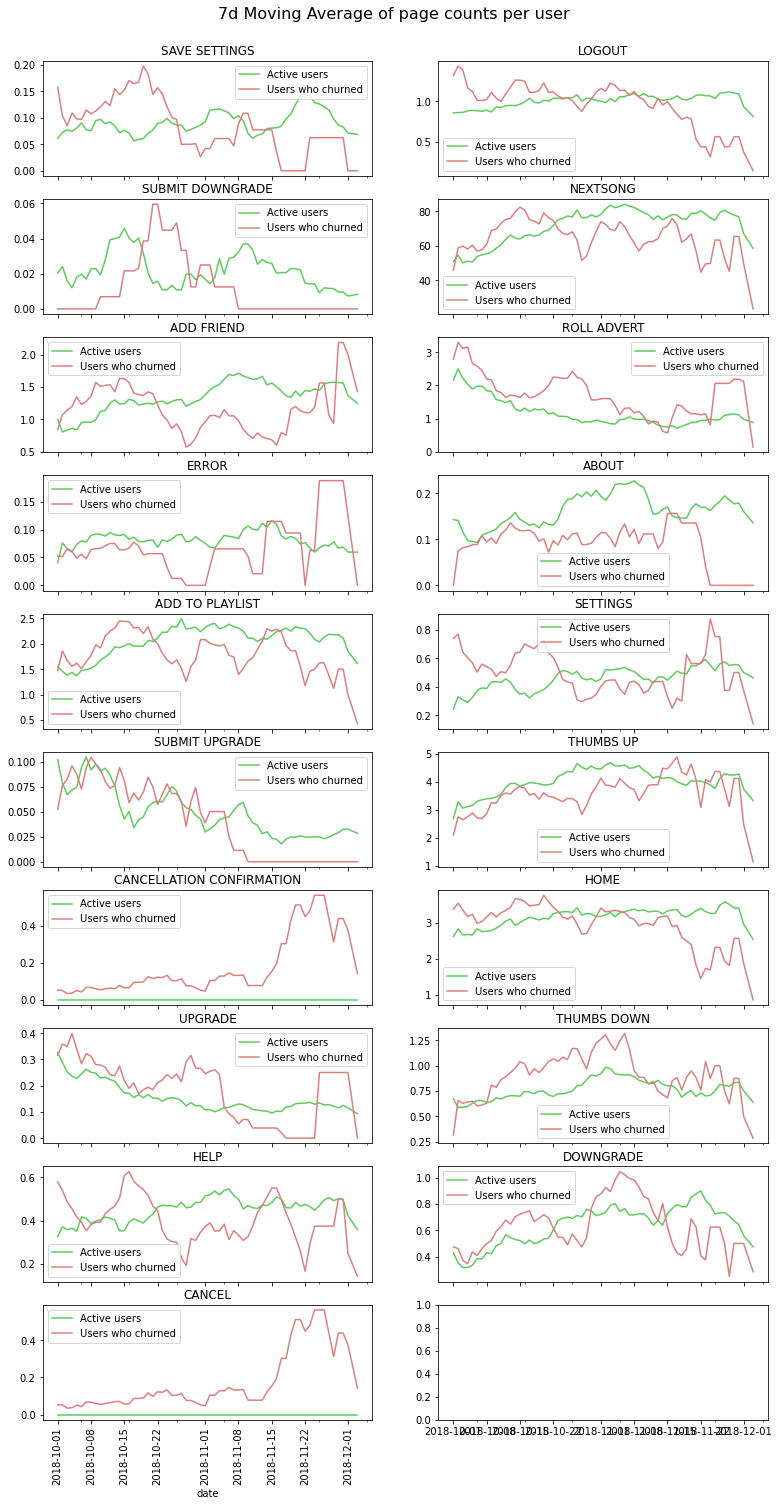

In [263]:
page_list = pd_df.page.unique().tolist()
month_day_fmt = mdates.DateFormatter('%m-%d') 
rows = round(len(page_list)/2)
cols = 2
ax_height = 2.5
ax_width = 6.5
fig_height = ax_height*rows
fig_width = ax_width*cols

fig, ax = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=True)
fig.suptitle('7d Moving Average of page counts per user', size=16, y=0.91)
for page_name, a in zip(page_list, ax.flatten()):
    if page_name:
        page_df = pd_df.query('page == @page_name')
        page_df.pivot(index='date', columns='phase_cancelled', values='MA7pageCountPerUser').plot(rot=90, 
                                                                                                  title=page_name.replace('_', ' ').upper(), 
                                                                                                  ax=a,
                                                                                                 colors=['#5ccc5c', '#db7f7f']);
        a.legend(['Active users','Users who churned'])

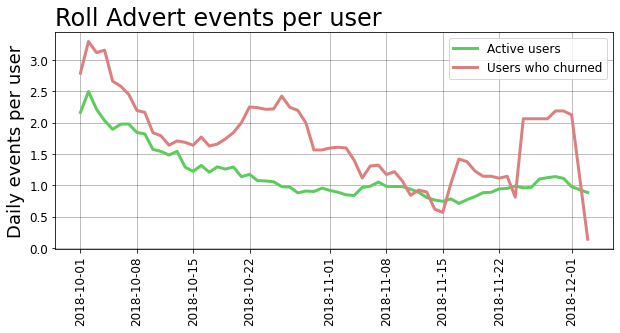

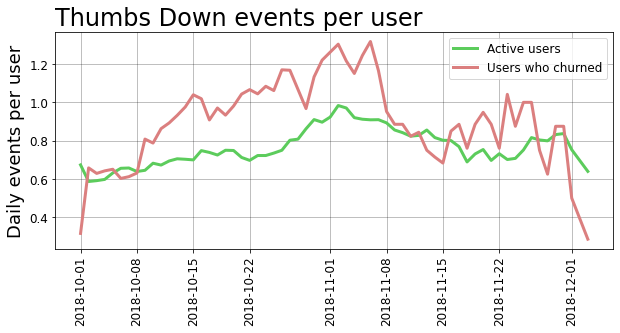

In [267]:
for page in ['Roll Advert', 'Thumbs Down']:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    page_df = pd_df.query('page == @page')
    page_df.pivot(index='date', columns='phase_cancelled', values='MA7pageCountPerUser').plot(rot=90, 
                                                                                              ax=ax,
                                                                                              colors=['#5ccc5c', '#db7f7f'],
                                                                                              lw=3,
                                                                                             fontsize=12);
    ax.legend(['Active users','Users who churned'], fontsize=12)
    plt.title(f'{page} events per user', size=24, loc='left')
    plt.grid(lw=0.5, c='black', alpha=0.5)
    plt.ylabel('Daily events per user', size=18)
    plt.xlabel('');

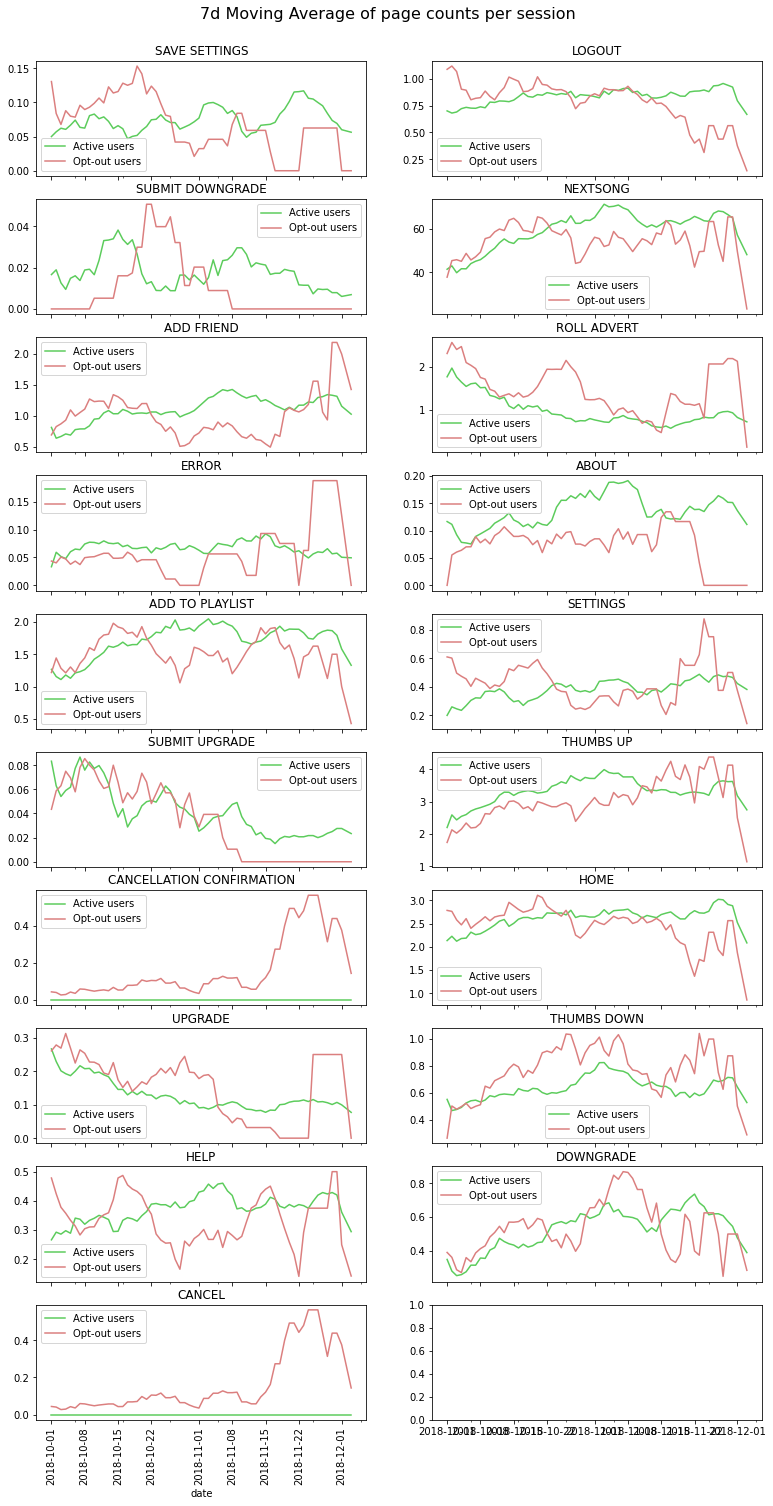

In [264]:
fig, ax = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=True)
fig.suptitle('7d Moving Average of page counts per session', size=16, y=0.91)
for page_name, a in zip(page_list, ax.flatten()):
    if page_name:
        page_df = pd_df.query('page == @page_name')
        page_df.pivot(index='date', columns='phase_cancelled', values='MA7pageCountPerSession').plot(rot=90, 
                                                                                                     title=page_name.replace('_', ' ').upper(), 
                                                                                                     ax=a,
                                                                                                    colors=['#5ccc5c', '#db7f7f']);
        a.legend(['Active users','Opt-out users'])

By looking on moving average of various measures calculated per user (i.e. divided by Daily Active Users), we can clearly see a positive relation between churn and **thumbs down** and **roll advert**. In order to confirm the observations, let's check the Spearman correlation coefficient between churn and the measures:

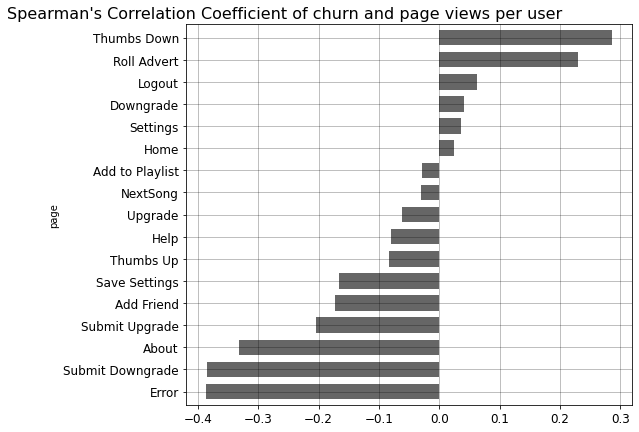

In [15]:
pd_df_filtered = pd_df.query('DAU != 0 & page != "Cancellation Confirmation" & page != "Cancel"')

corr_mpu = pd_df_filtered.pivot_table(index=['date', 'phase_cancelled'], columns='page', values='pageCountPerUser').reset_index('phase_cancelled').corr('spearman')['phase_cancelled'].drop('phase_cancelled')
corr_ma7_mpu = pd_df_filtered.pivot_table(index=['date', 'phase_cancelled'], columns='page', values='MA7pageCountPerUser').reset_index('phase_cancelled').corr('spearman')['phase_cancelled'].drop('phase_cancelled')

corr_mpu.dropna()\
         .sort_values().plot.barh(figsize=(8, 7), 
                                          fontsize=12, 
                                          alpha=0.6, 
                                          width=0.7, 
                                          color='black')

plt.title("Spearman's Correlation Coefficient of churn and page views per user", size=16, loc='left', x=-0.4)
plt.grid(lw=0.5, c='black', alpha=0.5)

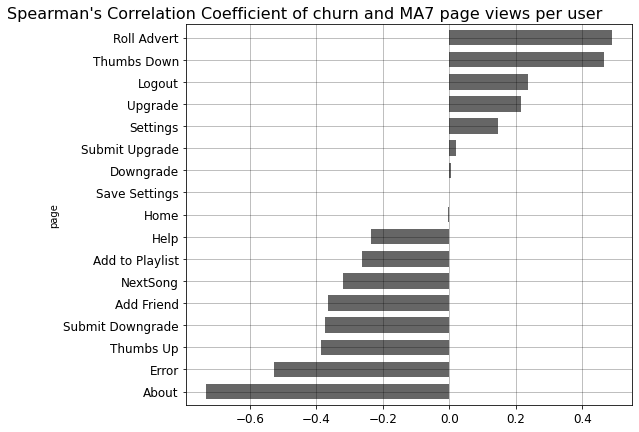

In [16]:
corr_ma7_mpu.dropna()\
         .sort_values().plot.barh(figsize=(8, 7), 
                                          fontsize=12, 
                                          alpha=0.6, 
                                          width=0.7, 
                                          color='black')

plt.title("Spearman's Correlation Coefficient of churn and MA7 page views per user", size=16, loc='left', x=-0.4)
plt.grid(lw=0.5, c='black', alpha=0.5)

In [17]:
corr_mpu = pd.DataFrame(corr_mpu).reset_index().sort_values(by='page').rename(columns={'page': 'feature', 'phase_cancelled':'corr'})
corr_ma7_mpu = pd.DataFrame(corr_ma7_mpu).reset_index().sort_values(by='page').drop('page', axis=1).rename(columns={'phase_cancelled': 'ma7_corr'})
corrs = pd.concat([corr_mpu, corr_ma7_mpu], axis=1).dropna(subset=['corr', 'ma7_corr'], how='all').set_index('feature').sort_values(by='ma7_corr', ascending=False)

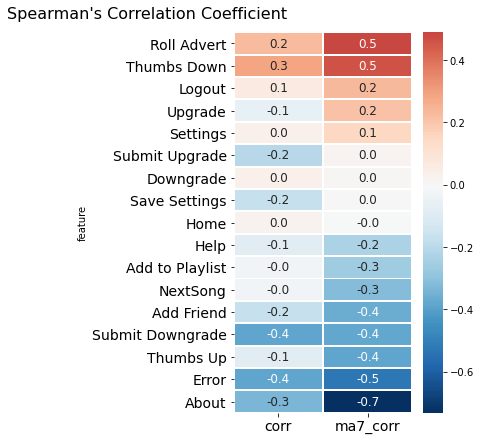

In [18]:
plt.figure(figsize=(4,7), dpi=72)
ax = sns.heatmap(corrs, annot=True, fmt='.1f', cmap='RdBu_r', center=0, lw=1, annot_kws={'fontsize':12}); #'RdBu_r', 
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title("Spearman's Correlation Coefficient", size=16, y=1.02, x=0.3, loc='right');

We observe multiple, quite high, positive Spearmann correlation coefficients for the calculated features (`corr`), additionally expressed by the moving average (`ma7_corr`). The highest positive correlation for **Roll Advert** amd **Thumbs Down**, weak correlation for **Logout** and **Upgrade**. 
We can see also the high negative correlation with **About** and **Error**. Negative correlation occured also for: **Thumbs Up**, **Submit Downgrade**, **Add Frient**, **Next Song**, **Add to Playlist** and **Help**. 

**There still are some questions to be answered:**
* **What is the average session duration?** 
* **What is the average sequence lenght?**

In [19]:
sess = df.groupby('phase_cancelled', 'userId', 'sessionId')\
    .agg(F.max('itemInSession').alias('maxItemInSession'))\
    .groupby('phase_cancelled', 'userId')\
    .agg(F.mean('maxItemInSession').alias('avgItemsInSession'))

In [20]:
pd_sess = sess.toPandas()

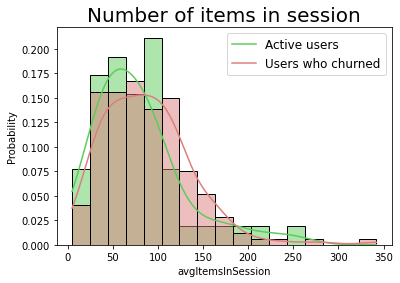

In [306]:
sns.histplot(data=pd_sess, 
             x='avgItemsInSession', 
             hue='phase_cancelled', 
             kde=True, 
             common_norm=False, 
             stat='probability', 
             palette=['#db7f7f', '#5ccc5c'])
plt.title('Number of items in session', size=20)
plt.legend(['Active users', 'Users who churned'],fontsize=12,);

**Active users have quite more items in a single session.**

In [22]:
pd_sess.corr('spearman')['phase_cancelled']['avgItemsInSession']

-0.10973247317466044

Spearmans coefficient confirms this observation, however the value is close to 0.

In [23]:
regs = df.select('date', 'phase_cancelled', 'userId','days_from_registration').distinct().toPandas()

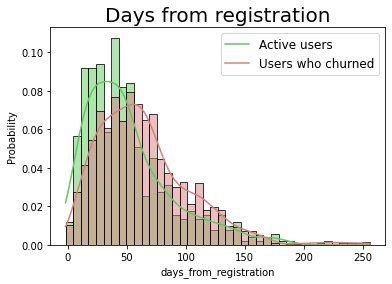

In [310]:
sns.histplot(data=regs, 
             x='days_from_registration', 
             hue='phase_cancelled', 
             kde=True, 
             common_norm=False, 
             stat='probability',
             palette=['#db7f7f', '#5ccc5c'])

plt.title('Days from registration', size=20)
plt.legend(['Active users', 'Users who churned'], fontsize=12,);

**Users who churned are more likely to have an account shorter time than active users.**

In [25]:
genders = df.select('phase_cancelled', 'userId','gender').distinct().toPandas()

In [26]:
genders_gr = genders.groupby(['phase_cancelled', 'gender']).count().reset_index().pivot(index='gender', columns='phase_cancelled', values='userId')
genders_gr = genders_gr.T

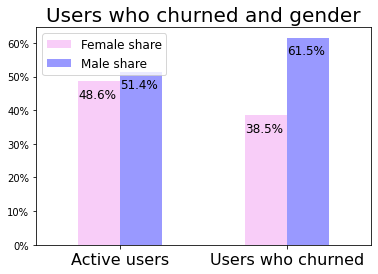

In [300]:
genders_gr['F share'] = genders_gr['F'] / (genders_gr['F'] + genders_gr['M'])
genders_gr['M share'] = genders_gr['M'] / (genders_gr['F'] + genders_gr['M'])
ax = genders_gr[['F share', 'M share']].plot.bar(rot=0, colors=['violet', 'blue'], alpha=0.4)
ax.axes.set_xticklabels(['Active users', 'Users who churned'], size=16)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.legend(['Female share', 'Male share'], fontsize=12, loc='upper left')
plt.title('Users who churned and gender', size=20)
annot_params = {'va': 'top', 'ha': 'left', 'color': 'black', 'fontsize': 12}

for i in range(4):
    x = ax.get_children()[i].get_x()
    y = ax.get_children()[i].get_height()
    annot = f'{y*100:.1f}%'
    ax.annotate(annot, xy=(x, y-0.02), **annot_params);

**Males are dominates in users who churned.**

For how many users who churned there is a monthly data available?

In [28]:
df.filter('page == "Cancellation Confirmation"').groupby('date').agg(F.countDistinct('userId').alias('cancellations')).orderBy('date').collect()

[Row(date=datetime.date(2018, 10, 1), cancellations=1),
 Row(date=datetime.date(2018, 10, 2), cancellations=1),
 Row(date=datetime.date(2018, 10, 4), cancellations=1),
 Row(date=datetime.date(2018, 10, 5), cancellations=2),
 Row(date=datetime.date(2018, 10, 7), cancellations=2),
 Row(date=datetime.date(2018, 10, 8), cancellations=1),
 Row(date=datetime.date(2018, 10, 11), cancellations=1),
 Row(date=datetime.date(2018, 10, 12), cancellations=2),
 Row(date=datetime.date(2018, 10, 13), cancellations=1),
 Row(date=datetime.date(2018, 10, 14), cancellations=1),
 Row(date=datetime.date(2018, 10, 15), cancellations=2),
 Row(date=datetime.date(2018, 10, 16), cancellations=1),
 Row(date=datetime.date(2018, 10, 17), cancellations=3),
 Row(date=datetime.date(2018, 10, 19), cancellations=1),
 Row(date=datetime.date(2018, 10, 20), cancellations=3),
 Row(date=datetime.date(2018, 10, 22), cancellations=2),
 Row(date=datetime.date(2018, 10, 23), cancellations=1),
 Row(date=datetime.date(2018, 10, 24)

# Feature Engineering

In [29]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancelled=0, phase_cancelled=0, datetime='2018-10-08 12:58:54', date=datetime.date(2018, 10, 8), month=10, datetime_registered='2018-09-27 02:45:40', date_registered=datetime.date(2018, 9, 27), month_registered=9, days_from_registration=11)]

In [317]:
# CONFIG
DATASET_MINI_PATH = 'mini_sparkify_event_data.json'
SPARK_APP_NAME = "Sparkify"
TRAIN_TEST_SPLIT_RATE = [0.7, 0.3]
LABEL_ALIAS = "label"
RAW_FEATURES_ALIAS = "raw_features"
FEATURES_ALIAS = "features"
SEED = 2137
DAYS_ACTIVITY_LIMIT = 30

In [318]:
spark.stop()
spark = session.SparkSession.builder \
    .master("local") \
    .appName(SPARK_APP_NAME) \
    .getOrCreate()

df = spark.read.json(DATASET_MINI_PATH)


# Exclude logout users
df = df.filter(df["userId"] != "")

# Flag churn events
flag_cancelled_auth_event = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, ByteType())
df = df.withColumn("cancelled", flag_cancelled_auth_event("page"))

# Consider the full range of rows partitioned by 'userId'. We know that `Cancellation Confirmation` is the last event 
# for the all users, that have it. 
windowval = Window.partitionBy("userId")
df = df.withColumn("phaseCancelled", F.max("cancelled").over(windowval).cast(ByteType()))

# Exclude unnecessary fields
df = df.filter(df.page != "Cancellation Confirmation")
df = df.filter(df.page != "Cancel")
df = df.filter(df.page != "Home")

# Convert timestamps to datetime format
df = df.withColumn('datetime', F.from_unixtime(col("ts") / 1000))
df = df.withColumn('datetimeReg', F.from_unixtime(col("registration") / 1000))

# Calculate number of days from registration
df = df.withColumn('daysFromReg', F.datediff(col('datetime'), col('datetimeReg')).cast(ShortType()))
df = df.withColumn('lastActivity', F.max('datetime').over(windowval))

# Calculate number days of last activity and keep records of DAYS_ACTIVITY_LIMIT from last activity
df = df.withColumn('daysFromLastActivity', F.datediff(col('lastActivity'), col('datetime')).cast(ShortType()))
df = df.filter(df.daysFromLastActivity < DAYS_ACTIVITY_LIMIT)

# Encode gender
encode_gender = F.udf(lambda x: 1 if x == "M" else 0, ByteType())
df = df.withColumn("isMale", encode_gender("gender"))

avgItemsInSession = df.groupby('userId', 'sessionId')\
                        .agg(F.max('itemInSession').alias('maxItemInSession'))\
                        .groupby('userId')\
                        .agg(F.mean('maxItemInSession').cast(ShortType()).alias('avgItemsInSession'))

# IntegerType, DecimalType, FloatType, ByteType, ShortType, BinaryType, BooleanType
def days(i):
    return i*86400

users_sessions = df.groupby('userId', 'isMale', 'phaseCancelled').agg(F.countDistinct('sessionId').alias('sessCount'),
                                                            F.max('daysFromReg').cast(ShortType()).alias('daysFromReg'))

users_events = df.groupby('userId', 'page').agg(F.count('sessionId').alias('pageCount'))
users_sessions = users_sessions.join(users_events, on='userId', how='left')\
                               .join(avgItemsInSession, on='userId', how='left')

users_sessions = users_sessions.withColumn('pageCountPerSess', (col('pageCount') / col('sessCount')).cast(DecimalType(6, 2)))
final_df = users_sessions.select('phaseCancelled', 'userId', 'isMale', 'avgItemsInSession', 'daysFromReg', 'page', 'sessCount', 'pageCountPerSess', 'pageCount')\
    .groupby('phaseCancelled', 'userId', 'isMale', 'avgItemsInSession', 'daysFromReg', 'sessCount').pivot('page').agg(F.avg('pageCountPerSess').alias('CPS'), 
                                                                                                                       F.avg('pageCount').alias('C'))
final_df = final_df.fillna(0)

In [319]:
inputCols = [
 'avgItemsInSession',
 'daysFromReg',
 'isMale',
 'sessCount',
 'About_CPS',
 'About_C',
#  'Add Friend_CPS',
 'Add Friend_C',
 'Add to Playlist_CPS',
#  'Add to Playlist_C',
 'Downgrade_CPS',
 'Downgrade_C',
 'Error_CPS',
 'Error_C',
 'Help_CPS',
 'Help_C',
#  'Logout_CPS',
 'Logout_C',
 'NextSong_CPS',
 'NextSong_C',
 'Roll Advert_CPS',
#  'Roll Advert_C',
 'Save Settings_CPS',
 'Save Settings_C',
 'Settings_CPS',
 'Settings_C',
 'Submit Downgrade_CPS',
 'Submit Downgrade_C',
 'Submit Upgrade_CPS',
 'Submit Upgrade_C',
 'Thumbs Down_CPS',
 'Thumbs Down_C',
 'Thumbs Up_CPS',
#  'Thumbs Up_C',
 'Upgrade_CPS'
#  'Upgrade_C'
]

assembler = VectorAssembler(inputCols=inputCols, outputCol=RAW_FEATURES_ALIAS)
final_df = assembler.transform(final_df)

normalizer = Normalizer(inputCol=RAW_FEATURES_ALIAS, outputCol=FEATURES_ALIAS)
final_df = normalizer.transform(final_df)

dataset = final_df.select(col("phaseCancelled").alias(LABEL_ALIAS), col(FEATURES_ALIAS))
train, test = dataset.randomSplit(TRAIN_TEST_SPLIT_RATE, seed=SEED)

In [320]:
dataset.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(30,[0,1,3,4,5,6,...|
+-----+--------------------+
only showing top 1 row



In [321]:
final_df.show(1, vertical=True)

-RECORD 0------------------------------------
 phaseCancelled       | 0                    
 userId               | 100010               
 isMale               | 0                    
 avgItemsInSession    | 72                   
 daysFromReg          | 55                   
 sessCount            | 3                    
 About_CPS            | 0.330000             
 About_C              | 1.0                  
 Add Friend_CPS       | 0.330000             
 Add Friend_C         | 1.0                  
 Add to Playlist_CPS  | 1.670000             
 Add to Playlist_C    | 5.0                  
 Downgrade_CPS        | 0.000000             
 Downgrade_C          | 0.0                  
 Error_CPS            | 0.000000             
 Error_C              | 0.0                  
 Help_CPS             | 0.330000             
 Help_C               | 1.0                  
 Logout_CPS           | 1.000000             
 Logout_C             | 3.0                  
 NextSong_CPS         | 51.670000 

In [322]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   35|
|    0|  122|
+-----+-----+



In [323]:
# Calculate weights for logistic regression
labels = train.groupby('label').count().toPandas()
labels.set_index('label', inplace=True)

label_0_cnt, label_1_cnt = labels.loc[[0,1], 'count']
label_0_weight = 1.0
label_1_weight = label_1_cnt / label_0_cnt


In [324]:
assign_weight = F.udf(lambda x: label_1_weight if x == 1 else label_0_weight, FloatType())

In [325]:
train = train.withColumn('weightCol', assign_weight(col('label')))
train.take(1)

[Row(label=0, features=SparseVector(30, {0: 0.3845, 1: 0.2937, 3: 0.016, 4: 0.0018, 5: 0.0053, 6: 0.0053, 7: 0.0089, 12: 0.0018, 13: 0.0053, 14: 0.016, 15: 0.276, 16: 0.8278, 17: 0.0534, 26: 0.0071, 27: 0.0214, 28: 0.0196, 29: 0.0018}), weightCol=1.0)]

# Modelling

In [347]:
def classification_report(test_results, train_results):
    """Calculate classification report based provided test and train set labels and predictions.
    Returns: dictionary containing classification report."""
    
    s = time()
    for dataset, dataset_label in [(train_results, 'train'), (test_results, 'test')]:
        counts = dataset.groupby('label', 'prediction').count()
        counts_list = list(map(lambda row: row.asDict(), counts.collect()))

        eval_map = { 
            'TP' : [1.0, 1.0], 
            'FP' : [0.0, 1.0],
            'TN' : [0.0, 0.0],
            'FN' : [1.0, 0.0]
        }

        dict_res = {}

        for d in counts_list:
            for name, (label_val, pred_val)  in eval_map.items():
                if d['label'] == label_val and d['prediction'] == pred_val:
                    dict_res[name] = d['count']

        for name in eval_map.keys():
            if name not in dict_res.keys():
                dict_res[name] = 0

        dict_res['TOTAL'] = sum(dict_res.values())
        dict_res['ACC'] = (dict_res['TP'] + dict_res['TN']) / dict_res['TOTAL']
        dict_res['PR'] = dict_res['TP'] / (dict_res['TP'] + dict_res['FP'])
        dict_res['RC'] = dict_res['TP'] / (dict_res['TP'] + dict_res['FN'])
        dict_res['FSCORE'] = 2 * (dict_res['PR'] * dict_res['RC']) / (dict_res['PR'] + dict_res['RC'])
        
        print(f'---- {dataset_label.upper()} ----')
        print('MEASURE\tVALUE')
        for key, val in dict_res.items():
            print(f'{key}:\t{val:.2f}')
        print('')
    
    e = time()
    delta = e-s
    print(f'Eval time: {delta:.2f}s')
    return dict_res


In [348]:
def train_and_predict(method):
    """Train model and evaluate"""
    
    m = method.fit(train)
    test_results = m.transform(test)
    train_results = m.transform(train)
    r = classification_report(test_results, train_results)
    return m, r

In [349]:
%%time
lr = LogisticRegression(maxIter=100, regParam=0.0, weightCol='weightCol')
lr_model, lr_report = train_and_predict(lr)

---- TRAIN ----
MEASURE	VALUE
FN:	20.00
TN:	121.00
TP:	15.00
FP:	1.00
TOTAL:	157.00
ACC:	0.87
PR:	0.94
RC:	0.43
FSCORE:	0.59

---- TEST ----
MEASURE	VALUE
FN:	12.00
TN:	49.00
TP:	5.00
FP:	2.00
TOTAL:	68.00
ACC:	0.79
PR:	0.71
RC:	0.29
FSCORE:	0.42

Eval time: 75.49s
CPU times: user 3.79 s, sys: 1.23 s, total: 5.02 s
Wall time: 5min 14s


In [350]:
rf = RandomForestClassifier(numTrees=100, maxDepth=10, seed=2021,  minInstancesPerNode=3, subsamplingRate=0.7)
rf_model, rf_report = train_and_predict(rf)

---- TRAIN ----
MEASURE	VALUE
FN:	11.00
TN:	122.00
TP:	24.00
FP:	0.00
TOTAL:	157.00
ACC:	0.93
PR:	1.00
RC:	0.69
FSCORE:	0.81

---- TEST ----
MEASURE	VALUE
FN:	14.00
TN:	51.00
TP:	3.00
FP:	0.00
TOTAL:	68.00
ACC:	0.79
PR:	1.00
RC:	0.18
FSCORE:	0.30

Eval time: 80.20s


In [351]:
%%time
gbt = GBTClassifier(featuresCol='features', 
                    labelCol='label', 
                    predictionCol='prediction', 
                    maxDepth=10, 
                    maxBins=32, 
                    minInstancesPerNode=4, 
                    minInfoGain=0.0, 
                    maxMemoryInMB=256, 
                    cacheNodeIds=False, 
                    checkpointInterval=10, 
                    lossType='logistic', 
                    maxIter=20, 
                    stepSize=0.1, 
                    seed=2021, 
                    subsamplingRate=0.6, 
                    featureSubsetStrategy='all')

gbt_model, gbt_report = train_and_predict(gbt)

---- TRAIN ----
MEASURE	VALUE
TN:	122.00
TP:	35.00
FP:	0.00
FN:	0.00
TOTAL:	157.00
ACC:	1.00
PR:	1.00
RC:	1.00
FSCORE:	1.00

---- TEST ----
MEASURE	VALUE
FN:	13.00
TN:	42.00
TP:	4.00
FP:	9.00
TOTAL:	68.00
ACC:	0.68
PR:	0.31
RC:	0.24
FSCORE:	0.27

Eval time: 76.98s
CPU times: user 7.33 s, sys: 2.38 s, total: 9.71 s
Wall time: 11min 17s


In [333]:
rf = RandomForestClassifier(seed=2021, minInstancesPerNode=4, subsamplingRate=0.6)
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 30])\
    .addGrid(rf.maxDepth, [7, 12]).build()

cv = CrossValidator(estimator=rf,
                   estimatorParamMaps=paramGrid,
                   evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                   numFolds=2)

In [334]:
%%time
cv_rf_model, cv_rf_report = train_and_predict(cv)

---- TRAIN ----
MEASURE	VALUE
FN:	24.00
TN:	120.00
TP:	11.00
FP:	2.00
TOTAL:	157.00
ACC:	0.83
PR:	0.85
RC:	0.31
FSCORE:	0.46

---- TEST ----
MEASURE	VALUE
FN:	13.00
TN:	50.00
TP:	4.00
FP:	1.00
TOTAL:	68.00
ACC:	0.79
PR:	0.80
RC:	0.24
FSCORE:	0.36

Eval time: 71.22s
CPU times: user 3.57 s, sys: 1.7 s, total: 5.27 s
Wall time: 10min 4s


In [335]:
%%time
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 8])\
    .addGrid(gbt.stepSize, [0.1, 0.05])\
    .addGrid(gbt.maxIter, [10, 30]).build()

gbt = GBTClassifier(featuresCol='features', 
                    labelCol='label', 
                    predictionCol='prediction', 
                    maxBins=32, 
                    minInstancesPerNode=3, 
                    minInfoGain=0.0, 
                    maxMemoryInMB=512, 
                    cacheNodeIds=False, 
                    checkpointInterval=10, 
                    lossType='logistic', 
                    seed=2021, 
                    subsamplingRate=0.9, 
                    featureSubsetStrategy='all')

cv_gbt = CrossValidator(estimator=gbt,
                   estimatorParamMaps=paramGrid,
                   evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                   numFolds=2)

cv_gbt_model, cv_gbt_report = train_and_predict(cv_gbt)

---- TRAIN ----
MEASURE	VALUE
TN:	122.00
TP:	35.00
FP:	0.00
FN:	0.00
TOTAL:	157.00
ACC:	1.00
PR:	1.00
RC:	1.00
FSCORE:	1.00

---- TEST ----
MEASURE	VALUE
FN:	12.00
TN:	46.00
TP:	5.00
FP:	5.00
TOTAL:	68.00
ACC:	0.75
PR:	0.50
RC:	0.29
FSCORE:	0.37

Eval time: 73.28s
CPU times: user 59.1 s, sys: 23.4 s, total: 1min 22s
Wall time: 1h 31min 41s


In [339]:
n_input = len(inputCols)
layers = [n_input, 8, 4, 2]
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=64, seed=SEED)
nn_model, nn_report = train_and_predict(trainer)

---- TRAIN ----
MEASURE	VALUE
FN:	28.00
TN:	121.00
TP:	7.00
FP:	1.00
TOTAL:	157.00
ACC:	0.82
PR:	0.88
RC:	0.20
FSCORE:	0.33

---- TEST ----
MEASURE	VALUE
FN:	15.00
TN:	47.00
TP:	2.00
FP:	4.00
TOTAL:	68.00
ACC:	0.72
PR:	0.33
RC:	0.12
FSCORE:	0.17

Eval time: 71.76s


# Conclusions
All of trained models are quite poor, 
Provided data sample could be not enough to identify patterns in users behaviour. 

Data require further investigation. There is a lot of topics that should be further explored. Ideas:
* features based on trends (decrease/increase of page views WoW or MoM)
* investigate locations/levels/userAgents
* investigate false-negatives